In [1]:
!pip install -q boto3
#!pip install -q scikit-learn==0.20.3
#!pip install -q nltk==3.4.5

tensorflow 2.0.0 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
awscli 1.18.11 has requirement botocore==1.15.11, but you'll have botocore 1.14.17 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

# Copy the datasets from S3 to this notebook instance

In [3]:
# $S3_BUCKET/feature-store/amazon-reviews/balanced-tfidf-without-header/data.csv

prefix_train = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/train'
prefix_validation = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/validation'
prefix_test = 'feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test'

balanced_tfidf_without_header_train_path = './{}/data.csv'.format(prefix_train)
balanced_tfidf_without_header_validation_path = './{}/data.csv'.format(prefix_validation)
balanced_tfidf_without_header_test_path = './{}/data.csv'.format(prefix_test)

import os
os.makedirs(prefix_train, exist_ok=True)
os.makedirs(prefix_validation, exist_ok=True)
os.makedirs(prefix_test, exist_ok=True)

balanced_tfidf_without_header_train_s3_uri = 's3://{}/{}/data.csv'.format(bucket, prefix_train)
balanced_tfidf_without_header_validation_s3_uri = 's3://{}/{}/data.csv'.format(bucket, prefix_validation)
balanced_tfidf_without_header_test_s3_uri = 's3://{}/{}/data.csv'.format(bucket, prefix_test)

In [4]:
!aws s3 cp $balanced_tfidf_without_header_train_s3_uri $balanced_tfidf_without_header_train_path
!aws s3 cp $balanced_tfidf_without_header_validation_s3_uri $balanced_tfidf_without_header_validation_path
!aws s3 cp $balanced_tfidf_without_header_test_s3_uri $balanced_tfidf_without_header_test_path

download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/train/data.csv to feature-store/amazon-reviews/csv/balanced-tfidf-without-header/train/data.csv
download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/validation/data.csv to feature-store/amazon-reviews/csv/balanced-tfidf-without-header/validation/data.csv
download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test/data.csv to feature-store/amazon-reviews/csv/balanced-tfidf-without-header/test/data.csv


# Load the data
_Note:  `header=None`_

In [5]:
def load_dataset(path, sep, header):
    data = pd.read_csv(path, sep=sep, header=header)

    labels = data.iloc[:,0]
    features = data.drop(data.columns[0], axis=1)
    
    if header==None:
        # Adjust the column names after dropped the 0th column above
        # New column names are 0 (inclusive) to len(features.columns) (exclusive)
        new_column_names = list(range(0, len(features.columns)))
        features.columns = new_column_names

    return features, labels

In [6]:
# Load transformed features (is_positive_sentiment, f0, f1, ...)
X_train, y_train = load_dataset(path=balanced_tfidf_without_header_train_path, sep=',', header=None)
X_validation, y_validation = load_dataset(path=balanced_tfidf_without_header_validation_path, sep=',', header=None)
X_test, y_test = load_dataset(path=balanced_tfidf_without_header_test_path, sep=',', header=None)


In [7]:
X_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-1.374267,-0.050714,0.045965,-0.095681,-0.024208,0.007436,0.216955,0.007147,0.060115,0.277942,...,-0.415373,0.561119,-1.811970,-1.487271,1.334355,-0.111095,-1.137205,0.375588,-1.226315,0.547955
1,0.529102,2.247861,0.358011,-0.936623,0.731896,-0.610157,0.322760,-0.729128,-0.481300,0.049675,...,0.302437,-0.068900,-1.244739,-0.673367,-0.759639,0.706567,1.712414,1.353105,-2.656585,-4.183273
2,-0.380184,2.365970,0.049836,-0.843767,-0.139338,-0.119252,0.449532,-1.201568,-0.277406,0.020049,...,0.493798,-0.185715,0.235108,-0.328393,-0.467352,-0.273243,-0.386907,0.124661,-0.175889,-0.099774
3,1.064614,5.248541,-0.061233,-1.891208,-0.252330,-0.225504,1.168317,-2.427062,-0.604398,0.088185,...,-0.058719,-0.031181,0.012651,0.100166,0.065465,-0.070098,-0.051166,-0.042232,-0.000701,0.001512
4,1.645310,-1.132258,-0.507240,-0.634686,-0.430723,-0.046433,-0.450887,-0.575758,-0.753185,1.048091,...,1.435114,-0.754427,-0.632381,0.593440,-2.081549,-0.053485,0.141140,3.208629,-0.725039,1.515200


# Train model with XGBoost
This may take a few minutes.  Please be patient.

## Install xgboost

In [8]:
!pip install -q xgboost==0.90

tensorflow 2.0.0 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
awscli 1.18.11 has requirement botocore==1.15.11, but you'll have botocore 1.14.17 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Train the model
_This will take a few minutes.  Please be patient._

In [9]:
import xgboost as xgb
from xgboost import XGBClassifier

objective  = 'binary:logistic'
max_depth  = 5
num_round  = 1

model = XGBClassifier(objective=objective,
                      num_round=num_round,
                      max_depth=max_depth)

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, num_round=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

# Save Model

In [10]:
import os

import pickle as pkl

# See https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html
# Need to save with joblib or pickle.  `xgb.save_model()` does not save feature_names
model_dir  = './models/notebook/'

os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'xgboost-model')
pkl.dump(model, open(model_path, 'wb'))
print('Wrote model to {}'.format(model_path))

Wrote model to ./models/notebook/xgboost-model


# TODO:  Explain Model

# Restore Model 
This simulates restoring a model within an application.

In [11]:
import pickle as pkl

def model_fn(model_dir):
    model_path = os.path.join(model_dir, 'xgboost-model')
    model = pkl.load(open(model_path, 'rb'))
    return model

In [12]:
model_dir  = './models/notebook/'
model_restored = model_fn(model_dir)

# Plot the feature importance for this model
TODO:  Display the values of the features!

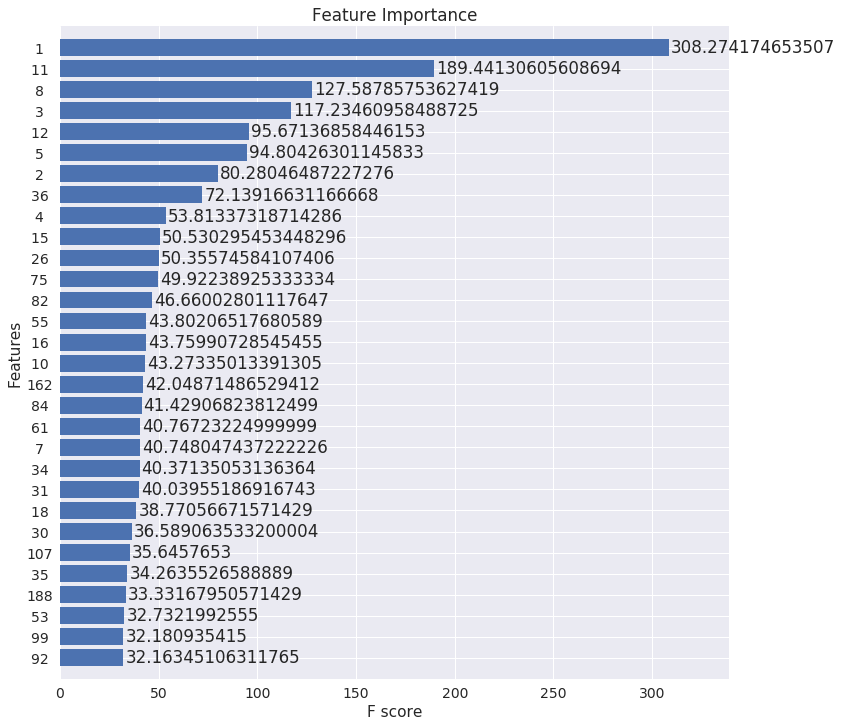

In [39]:
import matplotlib.pyplot as plt
import xgboost

fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(model_restored, 
                        importance_type='gain', 
                        max_num_features=30, 
                        height=0.8, 
                        ax=ax, 
                        show_values = True)
plt.title('Feature Importance')
plt.show()

# TODO:  Perform hyperparamter tuning?

# Calculate Validation Metrics

In [14]:
X_validation.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-1.132528,-0.285476,0.053968,0.038140,-0.283608,-0.108406,0.020732,-0.129295,-0.276727,-0.289023,...,0.554120,-0.021516,1.220065,0.475566,0.399135,0.959885,0.679964,-0.719911,0.531638,1.622707
1,0.923528,0.218951,2.296372,4.164058,2.483372,-0.315463,1.784855,-0.371005,-0.446929,-0.510526,...,-0.401928,-0.013532,0.382108,-0.194284,0.576342,-0.225719,-0.309982,-0.411781,-0.431115,-0.666721
2,1.532550,0.914452,3.294791,4.969701,1.820703,0.436111,-0.554552,-0.410368,0.976104,-0.135267,...,0.251235,-0.231907,-0.112117,-0.115742,-0.315052,-0.020291,-0.248348,-0.030948,0.048390,-0.054871
3,-0.727844,0.130914,1.153570,2.519989,2.374973,-0.617745,2.497208,-0.165353,-0.571808,-0.459117,...,-1.401332,1.865282,1.829885,-0.247646,-0.884709,0.751494,1.950942,0.441710,-0.190961,0.123571
4,-0.214197,-0.785744,-0.089758,0.094712,-0.327812,-0.340152,-0.499958,0.599231,-0.149729,-0.609919,...,-0.390823,-0.895934,-1.659191,0.716011,-0.771507,1.526343,-0.414299,0.083091,-0.291707,-0.908440


In [15]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

auc = model_restored.score(X_validation, y_validation)
print('Validation AUC: ', auc)

preds_validation = model_restored.predict(X_validation)
print('Validation Accuracy: ', accuracy_score(y_validation, preds_validation))
print('Validation Precision: ', precision_score(y_validation, preds_validation, average=None))

Validation AUC:  0.656934306569343
Validation Accuracy:  0.656934306569343
Validation Precision:  [0.7129771  0.62433393]


In [16]:
print(classification_report(y_validation, preds_validation))

              precision    recall  f1-score   support

           0       0.71      0.52      0.60       890
           1       0.62      0.79      0.70       891

   micro avg       0.66      0.66      0.66      1781
   macro avg       0.67      0.66      0.65      1781
weighted avg       0.67      0.66      0.65      1781



In [17]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm_validation = confusion_matrix(y_validation, preds_validation)
df_cm_validation


array([[467, 423],
       [188, 703]])

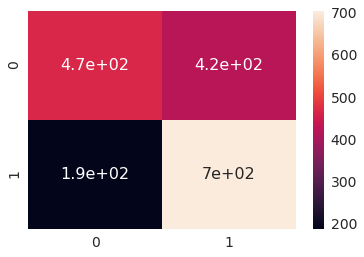

In [18]:
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_validation, annot=True, annot_kws={"size": 16}) # font size

# TODO:  Add labels to each quadrant (False, True / False, True)

plt.show()

# Test Metrics

In [19]:
X_test.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.634733,-0.247392,0.069444,-0.523243,-0.004713,-0.448801,-0.204092,-0.238300,-0.261760,-0.219047,...,0.164698,-0.557045,-0.381416,-0.103129,-0.209871,-0.556612,1.304991,0.499820,1.384731,-0.083465
1,1.258064,-1.061612,-0.027788,-0.435960,0.519479,-0.291335,0.263390,-0.780300,-0.411519,-0.517505,...,-0.080147,0.484613,0.113549,-0.315451,0.965301,-2.017522,0.042569,-0.315694,-1.637476,1.099162
2,-0.123441,-0.381155,0.220870,-0.306529,0.295466,0.015603,0.808974,-0.886816,-0.537187,-1.609552,...,0.907523,-1.370449,-0.497941,-0.000245,-0.229369,-0.549921,-0.901384,0.611026,0.231871,-1.763118
3,-0.085429,-0.558576,-0.111424,-0.648954,-0.045818,-0.389012,-0.304378,-0.226467,0.129833,-0.374666,...,1.990565,0.674278,1.541115,-1.362709,-0.785404,2.047984,0.874032,-0.547825,-0.133409,0.407323
4,0.943603,-0.748338,-0.302065,-0.454148,-0.777959,-1.025572,-0.138429,0.392192,-0.901120,0.385676,...,-0.930250,1.317045,-1.353617,0.330193,-0.600254,0.714468,-1.320635,-2.121154,-0.086226,-0.318210


In [20]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

auc = model_restored.score(X_test, y_test)
print('Test AUC ', auc)

preds_test = model_restored.predict(X_test)
print('Test Accuracy: ', accuracy_score(y_test, preds_test))
print('Test Precision: ', precision_score(y_test, preds_test, average=None))

Test AUC  0.6518809657495789
Test Accuracy:  0.6518809657495789
Test Precision:  [0.66504263 0.640625  ]


In [21]:
print(classification_report(y_test, preds_test))

              precision    recall  f1-score   support

           0       0.67      0.61      0.64       891
           1       0.64      0.69      0.66       890

   micro avg       0.65      0.65      0.65      1781
   macro avg       0.65      0.65      0.65      1781
weighted avg       0.65      0.65      0.65      1781



In [22]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm_test = confusion_matrix(y_test, preds_test)
df_cm_test

array([[546, 345],
       [275, 615]])

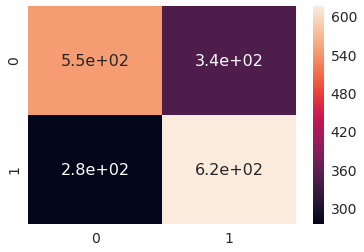

In [23]:
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm_test, annot=True, annot_kws={"size": 16}) # font size

# TODO:  Add labels to each quadrant (False, True / False, True)

plt.show()

# Predict in Notebook

Create `feature_transform_fn()` function (same used during `prepare` phase)

In [24]:
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

def feature_transform_fn(df_text, column_name, n_components):
    text_processors = Pipeline(
        steps=[
            (
                'tfidfvectorizer',
                TfidfVectorizer(
                    max_df=0.25,                                       
                    min_df=.0025,
                    analyzer='word',
                    max_features=10000
                )
            )
        ]
    )

    column_transformer = ColumnTransformer(
        transformers=[('text_processing', text_processors, df_text.columns.get_loc(column_name))]
    )

    pipeline = Pipeline(
        steps=[
            ('column_transformer',
             column_transformer), ('svd', TruncatedSVD(n_components=n_components)),
            ('standardscaler', StandardScaler())
        ]
    )

    return pipeline

In [25]:
# $S3_BUCKET/feature-store/amazon-reviews/balanced-raw-with-header/data.csv

prefix_raw = 'feature-store/amazon-reviews/csv/scrubbed-raw-with-header'

scrubbed_raw_path = './{}/data.csv'.format(prefix_raw)

import os
os.makedirs(prefix_raw, exist_ok=True)

scrubbed_raw_s3_uri = 's3://{}/{}/data.csv'.format(bucket, prefix_raw)

In [26]:
!aws s3 cp $scrubbed_raw_s3_uri $scrubbed_raw_path

download: s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/csv/scrubbed-raw-with-header/data.csv to feature-store/amazon-reviews/csv/scrubbed-raw-with-header/data.csv


In [27]:
X_raw, y_raw = load_dataset(path=scrubbed_raw_path, sep=',', header=0)
X_raw.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


In [28]:
y_raw.head(5)

0    1
1    1
2    1
3    1
4    1
Name: is_positive_sentiment, dtype: int64

In [29]:
np_tfidf = feature_transform_fn(X_raw, 'review_body', 300).fit_transform(X_raw)
df_tfidf = pd.DataFrame(np_tfidf)
df_tfidf.shape

(88391, 300)

In [30]:
df_tfidf.head(5)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.289098,-0.404276,-0.092323,-0.820442,-0.049913,0.322517,-0.226812,-1.519115,-3.034113,3.166949,...,0.163754,0.252119,0.670484,-0.414281,-0.425347,0.603074,-0.099094,-0.288254,0.621799,0.034120
1,-0.331193,-0.443682,-0.003247,-0.948043,0.220929,-0.154130,-0.582687,0.298183,0.112139,-0.104784,...,-0.693152,-1.941405,-0.703488,-0.487821,-0.067959,0.391526,0.446917,-0.779056,-0.552073,-1.053509
2,0.633477,-1.012941,-0.074319,-1.290266,-0.355626,0.016319,-0.433885,0.011414,0.062249,-0.633257,...,0.960468,1.025112,-0.446708,0.146653,0.671816,1.916124,-0.080514,0.707761,2.174551,0.575791
3,-0.319321,-0.431430,0.248694,-0.610628,0.042480,0.181592,-0.489522,-0.119443,0.014149,-0.405806,...,-0.604576,-0.025906,0.906446,0.858540,0.590409,-0.103005,-0.916739,-0.044799,0.255940,-0.493125
4,-0.310139,-0.493819,0.073357,-0.823057,-0.039401,-0.175325,-0.394827,0.160651,0.032373,-0.271306,...,-1.228790,0.014928,0.848897,-2.147418,0.878524,0.637840,-1.333630,-2.174684,2.409997,0.855401


In [31]:
X_raw.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


In [32]:
y_raw.head(5)

0    1
1    1
2    1
3    1
4    1
Name: is_positive_sentiment, dtype: int64

In [33]:
preds = model_restored.predict(df_tfidf)
df_preds = pd.DataFrame(preds)
df_preds.head(5)

,0
0,1
1,1
2,0
3,0
4,0


In [34]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

auc = model_restored.score(df_tfidf, y_raw)
print('Test AUC ', auc)

preds_raw = model_restored.predict(df_tfidf)
print('Test Accuracy: ', accuracy_score(y_raw, preds_raw))
print('Test Precision: ', precision_score(y_raw, preds_raw, average=None))

Test AUC  0.5699449038929303
Test Accuracy:  0.5699449038929303
Test Precision:  [0.24190788 0.83067333]


In [36]:
pd.read_csv(scrubbed_raw_path)

,is_positive_sentiment,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,1,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,1,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,1,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,1,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31
5,1,US,4772040,R1HCST57W334KN,B0112OSOQE,38517795,Rick and Morty Season 2,Digital_Video_Download,5,5,6,N,Y,Best show on TV right now,If you don't like this show. Go back to your n...,2015-08-31
6,1,US,12910040,R32BUTYQS1ZJBQ,B000NPE5SA,373323715,Africa Screams,Digital_Video_Download,4,1,1,N,Y,Very funny. A typical mid 50's comedy,Very funny. A typical mid 50's comedy.,2015-08-31
7,0,US,38805573,RH4SXPL4L9QU,B00XWV4QXG,633842417,Entourage: Season 7,Digital_Video_Download,3,0,0,N,Y,it was not as good as the series,"Strange as it is, it was not as good as the se...",2015-08-31
8,0,US,37100714,R37INWIQA5YW8N,B00X8UKOUK,666093513,Catastrophe - Season 1,Digital_Video_Download,2,0,0,N,Y,Two Stars,"Funny shows! We laughed out loud, alot!",2015-08-31
9,0,US,41234409,R18GSVAAS3N8GX,B00OOKXTFU,801680808,The Worricker Trilogy Season 1,Digital_Video_Download,3,0,0,N,Y,A tad Stuffy,Well made. Great actors! Christopher Walken ma...,2015-08-31


# TODO:  Deploy the model
1. Create a SageMaker endpoint using this model.

2. Define the predict function to transform raw text into TF/IDF.

In [37]:
# # TODO:  1) update this to do TF/IDF
# #        2) use this in other versions of the model
# # Derived from the following:
# #   https://aim357.readthedocs.io/en/latest/GluePySparkMLFeatureEngineering/GluePySparkMLFeatureEngineering.html#deepar-deep-dive

# class XGBoostPredictor(sagemaker.predictor.RealTimePredictor):

#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_CSV, **kwargs)

#     def predict(self, df):
#         """Requests the prediction of for the time series listed in `ts`, each with the (optional)
#         corresponding category listed in `cat`.

#         df -- `pandas.Series` object, the data frame to predict

#         Return value: list of `pandas.DataFrame` objects, each containing the predictions
#         """
#         req = self.__encode_request(df)
#         # TODO:  change this
#         res = predict(req) # super(DeepARPredictor, self).predict(req)
#         return self.__decode_response(res)

#     def __encode_request(self, df):
#         # TODO:  Add transform
# #        df = feature_transform
#         encoded_request = pd.DataFrame([0,1])
#         return encoded_request

#     def __decode_response(self, response):
#         predictions = response
#         return pd.DataFrame(data=predictions)

In [38]:
# xgb_endpoint_name = prefix + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

# xgb_predictor = xgb_estimator.deploy(
#                      initial_instance_count=1, 
#                      instance_type='local',
# #                     instance_type='ml.m4.xlarge',
#                      predictor_cls=XGBoostPredictor,
#                      endpoint_name=xgb_endpoint_name)

NameError: name 'prefix' is not defined